In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.dpi': 150})
# Use valid rcParams keys: set serif family and specify Times New Roman
plt.rcParams.update({'font.family': 'serif', 'font.serif': ['Times New Roman']})
import re
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv('/Users/ainsleylewis/Documents/Astronomy/arXiver/2025_Data.csv')
data

,title,abstract,authors,figures,pages,tables,pdf_link,primary_subject,secondary_subjects,submitted_journal,...,journals,num_checks,affiliations,total_citations,non_self_citations,journal_flag,journal_flag_with_submitted,smart_keywords,smart_keywords_2,latex_countries
0,Insights on Galaxy Evolution from Interpretabl...,Galaxy appearances reveal the physics of how t...,['John F. Wu'],4.0,10.0,2.0,arxiv.org/pdf/2501.00089,Astrophysics of Galaxies,['Machine Learning'],AAS Journals,...,"ApJ (2025), 980 183",0,"Wu, John F.: Space Telescope Science Institute...",3.0,1.0,1,1,"['Astronomers', 'Astronomical evolution', 'Ast...","['Galaxies (573)', 'Astronomy image processing...",NaN
1,X-ray reverberation black hole mass and distan...,We fit X-ray reverberation models to Rossi X-r...,"[""Patrick O'Neill"", 'Adam Ingram', 'Edward Nat...",16.0,18.0,1.0,arxiv.org/pdf/2501.12788,High Energy Astrophysical Phenomena,NaN,NaN,...,NaN,0,NaN,0.0,0.0,1,1,"['Accretion', 'Angular distance', 'Bayesian st...",['powered by accretion of matter from a compan...,"United Kingdom, United Kingdom, United Kingdom..."
2,The TES-based Cryogenic AntiCoincidence Detect...,The Cryogenic AntiCoincidence Detector (CryoAC...,"[""Matteo D'Andrea"", 'Claudio Macculi', 'Simone...",17.0,8.0,0.0,arxiv.org/pdf/2501.12781,Instrumentation and Methods for Astrophysics,NaN,IEEE Transactions on Applied Superconductivity...,...,NaN,0,"D'Andrea, Matteo: INAF/IAPS, 00133, Rome, Ital...",1.0,0.0,1,1,[],[],NaN
3,Massive star clusters in the gamma-ray sky: th...,Massive Star Clusters (SCs) have been proposed...,"['Giada Peron', 'Giovanni Morlino', 'Stefano G...",3.0,5.0,1.0,arxiv.org/pdf/2501.12767,High Energy Astrophysical Phenomena,NaN,NaN,...,NaN,0,NaN,0.0,0.0,0,0,"['Cosmic ray objects', 'Cosmic ray sources', '...","['Cosmic Rays 1', 'HII regions', 'Gamma rays',...","Italy, France"
4,The Impact of Bar-induced Non-Circular Motions...,We study the impact of bar-induced non-circula...,"['Jie Liu', 'Zhi Li', 'Juntai Shen']",12.0,19.0,1.0,arxiv.org/pdf/2501.12760,Astrophysics of Galaxies,NaN,NaN,...,NaN,0,"Liu, Jie: Shanghai Astronomical Observatory, C...",4.0,3.0,1,1,"['Disk galaxies', 'Galactic bar', 'Galaxies']",['galaxies: rotation curve - galaxies: fundame...,Germany
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18655,Cosmic Himalayas in CROCODILE : Probing the Ex...,The recently reported Cosmic Himalayas (CH) --...,"['Yuto Kuwayama', 'Yongming Liang', 'Kentaro N...",10.0,18.0,5.0,arxiv.org/pdf/2512.24966,Cosmology and Nongalactic Astrophysics,['Astrophysics of Galaxies'],NaN,...,NaN,0,"[None, None, None, None, None, None, None, Non...",0.0,0.0,0,1,"['Apparent anomaly', 'Clustering', 'Cosmologic...",['Hydrodynamicalsimulations(767)'],"Japan, Japan, Japan, Japan, Japan, Japan, Unit..."
18656,Multi-Frequency Study of FRB20201124A with the...,We present results from multi-epoch observatio...,"['C. Dudeja', 'J. Roy', 'U. Panda', 'S. Bhatta...",11.0,17.0,1.0,arxiv.org/pdf/2512.24978,High Energy Astrophysical Phenomena,NaN,NaN,...,NaN,0,"[None, None, None, None]",0.0,0.0,0,0,"['FRB', 'FRBs', 'Fast radio burst']",[],"India, India, India, India"
18657,Distributions of wide binary stars in theory a...,"Using the censored catalog of 103,169 resolved...",['Valeri V. Makarov'],7.0,13.0,1.0,arxiv.org/pdf/2512.25002,Solar and Stellar Astrophysics,NaN,NaN,...,NaN,0,[None],0.0,0.0,1,1,"['A stars', 'A type stars', 'A-type stars']",[],United States
18658,Towards precision cosmology with Voids x CMB c...,We construct and validate a set of multi-purpo...,"['Mar Pérez Sar', 'Carlos Hernández Monteagudo...",8.0,19.0,1.0,arxiv.org/pdf/2512.25040,Cosmology and Nongalactic Astrophysics,NaN,NaN,...,NaN,0,"[None, None, None, None]",0.0,0.0,0,1,"['CMB', 'Catalogs', 'Clustering']",['Cosmology: Large-scale structure - Cosmic mi...,"Spain, Spain, Hungary, Hungary, France, United..."


In [4]:
# Using affiliations column to get countries

# 1. Setup the replacement dictionary
replacement_dict = {
    'USA': 'United States',
    'UK': 'United Kingdom',
    'UAE': 'United Arab Emirates',
    'United States of America': 'United States',
    "People's Republic of China": 'China',
    'The Netherlands': 'Netherlands',
    'Republic of Korea': 'South Korea',
    'The United Kingdom': 'United Kingdom'
}

# 2. Load the reference countries
# Assuming 'world_coords.csv' is in the current directory
try:
    world_coords = pd.read_csv('/Users/ainsleylewis/Documents/Astronomy/arXiver/world_coords.csv')
    # Create a set of valid countries for O(1) lookup speed
    valid_countries = set(world_coords['country'].unique())
except FileNotFoundError:
    print("Error: 'world_coords.csv' not found. Please ensure the file exists.")
    valid_countries = set()

# 3. Define the extraction function
def extract_countries_from_affiliations(affil_text):
    """
    Parses an affiliation string, splits by semicolon, and extracts 
    countries based on the valid_countries list and replacement_dict.
    """
    if not isinstance(affil_text, str) or not affil_text:
        return []

    found_countries = []
    
    # Split the row containing multiple affiliations by ';'
    affiliations = affil_text.split(';')
    
    for affil in affiliations:
        affil = affil.strip()
        if not affil:
            continue
            
        # Strategy: Look at the text after the last comma first (standard address format),
        # then fall back to checking the end of the string.
        
        # Get the last part after the last comma
        if ',' in affil:
            last_part = affil.split(',')[-1].strip()
        else:
            last_part = affil

        # Remove trailing periods (e.g., "USA." -> "USA")
        last_part_clean = last_part.rstrip('.')
        
        country_candidate = None

        # Check 1: Is this exact text in our replacement dict?
        if last_part_clean in replacement_dict:
            country_candidate = replacement_dict[last_part_clean]
        
        # Check 2: Is this exact text a valid country?
        elif last_part_clean in valid_countries:
            country_candidate = last_part_clean
            
        # Check 3 (Fallback): If the address is complex, iterate through keys/countries
        # to see if the string ENDS with them.
        else:
            # Check replacements via regex at end of string
            for key, val in replacement_dict.items():
                # Matches "Key" at end of string, optionally followed by a dot
                if re.search(r'\b' + re.escape(key) + r'\.?$', affil):
                    country_candidate = val
                    break
            
            # If still not found, check valid countries via regex at end of string
            if not country_candidate:
                for country in valid_countries:
                    if re.search(r'\b' + re.escape(country) + r'\.?$', affil):
                        country_candidate = country
                        break

        # If we identified a valid country (and it exists in our reference list)
        if country_candidate:
            # Ensure the replaced name is actually in our valid list 
            # (e.g. if 'United States' is in world_coords)
            if country_candidate in valid_countries:
                found_countries.append(country_candidate)
            else:
                # If the replacement map gives "United States" but world_coords 
                # strictly uses "USA" (unlikely based on your dict, but good safety),
                # we keep the candidate.
                found_countries.append(country_candidate)
                
    return found_countries

# 4. Apply the function to the dataframe
# Assuming your dataframe is named 'data'
if 'data' in locals():
    data['affil_countries'] = data['affiliations'].apply(extract_countries_from_affiliations)

    # Display the result to verify
    print(data[['affiliations', 'affil_countries']].head())
else:
    print("Dataframe 'data' not found. Please load your data first.")

                                        affiliations  \
0  Wu, John F.: Space Telescope Science Institute...   
1                                                NaN   
2  D'Andrea, Matteo: INAF/IAPS, 00133, Rome, Ital...   
3                                                NaN   
4  Liu, Jie: Shanghai Astronomical Observatory, C...   

                                     affil_countries  
0      [United States, United States, United States]  
1                                                 []  
2  [Italy, Italy, Italy, Italy, Italy, Italy, Ita...  
3                                                 []  
4         [China, China, China, China, China, China]  


In [5]:
# For how many columns do we have counties in both affil_countries and latex_countries
count_both = 0
for affil_list, latex_list in zip(data['affil_countries'], data['latex_countries']):
    if affil_list and latex_list:
        count_both += 1
count_both

# Country name mismatches between affil_countries and latex_countries

def check_country_mismatches(df):
    """
    Identifies rows where the extracted 'affil_countries' list does not match 
    the parsed 'latex_countries' string.
    """
    
    # List to store indices of mismatching rows
    mismatch_indices = []

    # Iterate through the dataframe
    for index, row in df.iterrows():
        
        # 1. Get the generated list from the previous step
        derived_list = row['affil_countries']
        
        # 2. Get the manual/latex string
        latex_str = row['latex_countries']
        
        # 3. Filter: Only check rows that have valid entries in BOTH columns
        # Check if derived_list is valid (not None and not empty)
        has_derived = isinstance(derived_list, list) and len(derived_list) > 0
        
        # Check if latex_str is valid (not NaN/None and not empty string)
        has_latex = pd.notna(latex_str) and str(latex_str).strip() != ''
        
        if has_derived and has_latex:
            # 4. Convert latex string to list for comparison
            # Split by comma, strip whitespace around the country name
            latex_list = [c.strip() for c in str(latex_str).split(',') if c.strip()]
            
            # 5. Strict comparison (Order and Count must match exactly)
            if derived_list != latex_list:
                mismatch_indices.append(index)

    # 6. Create a dataframe subset containing only mismatches
    mismatched_rows = df.loc[mismatch_indices].copy()
    
    # Add a column showing the parsed latex list for easier visual comparison
    mismatched_rows['latex_list_parsed'] = mismatched_rows['latex_countries'].apply(
        lambda x: [c.strip() for c in str(x).split(',') if c.strip()]
    )
    
    return mismatched_rows

# --- Execution ---

# Run the check
mismatches = check_country_mismatches(data)

# Output results
if mismatches.empty:
    print("Success! No mismatches found between affiliations and latex_countries.")
else:
    print(f"Found {len(mismatches)} mismatches.")
    print("\nSample of mismatches (showing derived vs latex):")
    
    # specific columns to view
    cols_to_view = ['affil_countries', 'latex_list_parsed', 'affiliations']
    
    # Adjust pandas display options to ensure we see the full columns
    with pd.option_context('display.max_colwidth', None):
        print(mismatches[cols_to_view].head(10))

    # Optional: Save to CSV to inspect manually
    # mismatches.to_csv('country_mismatches.csv')


Found 7495 mismatches.

Sample of mismatches (showing derived vs latex):
                                                                                                                                                    affil_countries  \
4                                                                                                                        [China, China, China, China, China, China]   
5                                                                                     [China, China, China, China, China, China, China, China, China, China, China]   
6                                                                                                                                                   [United States]   
7                                                                                                                        [Spain, Spain, Spain, Spain, Spain, Spain]   
8   [Netherlands, United States, United States, United States, United States, United States,

In [6]:
data

,title,abstract,authors,figures,pages,tables,pdf_link,primary_subject,secondary_subjects,submitted_journal,...,num_checks,affiliations,total_citations,non_self_citations,journal_flag,journal_flag_with_submitted,smart_keywords,smart_keywords_2,latex_countries,affil_countries
0,Insights on Galaxy Evolution from Interpretabl...,Galaxy appearances reveal the physics of how t...,['John F. Wu'],4.0,10.0,2.0,arxiv.org/pdf/2501.00089,Astrophysics of Galaxies,['Machine Learning'],AAS Journals,...,0,"Wu, John F.: Space Telescope Science Institute...",3.0,1.0,1,1,"['Astronomers', 'Astronomical evolution', 'Ast...","['Galaxies (573)', 'Astronomy image processing...",NaN,"[United States, United States, United States]"
1,X-ray reverberation black hole mass and distan...,We fit X-ray reverberation models to Rossi X-r...,"[""Patrick O'Neill"", 'Adam Ingram', 'Edward Nat...",16.0,18.0,1.0,arxiv.org/pdf/2501.12788,High Energy Astrophysical Phenomena,NaN,NaN,...,0,NaN,0.0,0.0,1,1,"['Accretion', 'Angular distance', 'Bayesian st...",['powered by accretion of matter from a compan...,"United Kingdom, United Kingdom, United Kingdom...",[]
2,The TES-based Cryogenic AntiCoincidence Detect...,The Cryogenic AntiCoincidence Detector (CryoAC...,"[""Matteo D'Andrea"", 'Claudio Macculi', 'Simone...",17.0,8.0,0.0,arxiv.org/pdf/2501.12781,Instrumentation and Methods for Astrophysics,NaN,IEEE Transactions on Applied Superconductivity...,...,0,"D'Andrea, Matteo: INAF/IAPS, 00133, Rome, Ital...",1.0,0.0,1,1,[],[],NaN,"[Italy, Italy, Italy, Italy, Italy, Italy, Ita..."
3,Massive star clusters in the gamma-ray sky: th...,Massive Star Clusters (SCs) have been proposed...,"['Giada Peron', 'Giovanni Morlino', 'Stefano G...",3.0,5.0,1.0,arxiv.org/pdf/2501.12767,High Energy Astrophysical Phenomena,NaN,NaN,...,0,NaN,0.0,0.0,0,0,"['Cosmic ray objects', 'Cosmic ray sources', '...","['Cosmic Rays 1', 'HII regions', 'Gamma rays',...","Italy, France",[]
4,The Impact of Bar-induced Non-Circular Motions...,We study the impact of bar-induced non-circula...,"['Jie Liu', 'Zhi Li', 'Juntai Shen']",12.0,19.0,1.0,arxiv.org/pdf/2501.12760,Astrophysics of Galaxies,NaN,NaN,...,0,"Liu, Jie: Shanghai Astronomical Observatory, C...",4.0,3.0,1,1,"['Disk galaxies', 'Galactic bar', 'Galaxies']",['galaxies: rotation curve - galaxies: fundame...,Germany,"[China, China, China, China, China, China]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18655,Cosmic Himalayas in CROCODILE : Probing the Ex...,The recently reported Cosmic Himalayas (CH) --...,"['Yuto Kuwayama', 'Yongming Liang', 'Kentaro N...",10.0,18.0,5.0,arxiv.org/pdf/2512.24966,Cosmology and Nongalactic Astrophysics,['Astrophysics of Galaxies'],NaN,...,0,"[None, None, None, None, None, None, None, Non...",0.0,0.0,0,1,"['Apparent anomaly', 'Clustering', 'Cosmologic...",['Hydrodynamicalsimulations(767)'],"Japan, Japan, Japan, Japan, Japan, Japan, Unit...",[]
18656,Multi-Frequency Study of FRB20201124A with the...,We present results from multi-epoch observatio...,"['C. Dudeja', 'J. Roy', 'U. Panda', 'S. Bhatta...",11.0,17.0,1.0,arxiv.org/pdf/2512.24978,High Energy Astrophysical Phenomena,NaN,NaN,...,0,"[None, None, None, None]",0.0,0.0,0,0,"['FRB', 'FRBs', 'Fast radio burst']",[],"India, India, India, India",[]
18657,Distributions of wide binary stars in theory a...,"Using the censored catalog of 103,169 resolved...",['Valeri V. Makarov'],7.0,13.0,1.0,arxiv.org/pdf/2512.25002,Solar and Stellar Astrophysics,NaN,NaN,...,0,[None],0.0,0.0,1,1,"['A stars', 'A type stars', 'A-type stars']",[],United States,[]
18658,Towards precision cosmology with Voids x CMB c...,We construct and validate a set of multi-purpo...,"['Mar Pérez Sar', 'Carlos Hernández Monteagudo...",8.0,19.0,1.0,arxiv.org/pdf/2512.25040,Cosmology and Nongalactic Astrophysics,NaN,NaN,...,0,"[None, None, None, None]",0.0,0.0,0,1,"['CMB', 'Catalogs', 'Clustering']",['Cosmology: Large-scale structure - Cosmic mi...,"Spain, Spain, Hungary, Hung

In [7]:
# All countires column and first authors column

def process_country_columns(row):
    """
    Helper function to generate the 'all_countries' and 'first_author' data
    based on row values.
    """
    # --- Logic for 'all_countries' ---
    # Default to the extracted countries from affiliations
    final_all_countries = row['affil_countries']
    
    # Check if the list is empty or invalid (NaN/None)
    is_affil_empty = not isinstance(final_all_countries, list) or len(final_all_countries) == 0
    
    # If empty, fill from 'latex_countries'
    if is_affil_empty:
        latex_val = row.get('latex_countries')
        if pd.notna(latex_val) and str(latex_val).strip() != '':
            # Convert comma-separated string to list
            final_all_countries = [x.strip() for x in str(latex_val).split(',') if x.strip()]
        else:
            final_all_countries = []

    # --- Logic for 'first_author' ---
    first_author_countries = []
    affil_text = row.get('affiliations')
    
    # 1. Try to get first author from 'affiliations' column
    # We split by ';' and take the first segment (index 0)
    if pd.notna(affil_text) and str(affil_text).strip() != '':
        first_segment = str(affil_text).split(';')[0]
        # Use the function defined in Step 1 to extract country from just this segment
        first_author_countries = extract_countries_from_affiliations(first_segment)
    
    # 2. If no country found in affiliations, fallback to first entry of 'latex_countries'
    if not first_author_countries:
        latex_val = row.get('latex_countries')
        if pd.notna(latex_val) and str(latex_val).strip() != '':
            # Split by comma and take the first item
            first_latex_country = str(latex_val).split(',')[0].strip()
            if first_latex_country:
                first_author_countries = [first_latex_country]

    return pd.Series([final_all_countries, first_author_countries])

# Apply the logic to the dataframe
if 'data' in locals():
    data[['all_countries', 'first_author']] = data.apply(process_country_columns, axis=1)

    # Display results to verify
    cols_to_show = ['affiliations', 'latex_countries', 'all_countries', 'first_author']
    print(data[cols_to_show].head())
else:
    print("Dataframe 'data' not found.")

                                        affiliations  \
0  Wu, John F.: Space Telescope Science Institute...   
1                                                NaN   
2  D'Andrea, Matteo: INAF/IAPS, 00133, Rome, Ital...   
3                                                NaN   
4  Liu, Jie: Shanghai Astronomical Observatory, C...   

                                     latex_countries  \
0                                                NaN   
1  United Kingdom, United Kingdom, United Kingdom...   
2                                                NaN   
3                                      Italy, France   
4                                            Germany   

                                       all_countries      first_author  
0      [United States, United States, United States]   [United States]  
1  [United Kingdom, United Kingdom, United Kingdo...  [United Kingdom]  
2  [Italy, Italy, Italy, Italy, Italy, Italy, Ita...           [Italy]  
3                                 

In [8]:
# Percentage of rows for which we have countries in 'all_countries' and 'first_author' columns

def calculate_fill_percentage(df, col_name):
    """
    Calculates the percentage of rows where col_name is a non-empty list.
    """
    total_rows = len(df)
    
    if total_rows == 0:
        return 0.0
    
    # Check if the value is a list AND has items in it
    # isinstance(x, list) filters out NaNs (floats) and None types safely
    non_empty_count = df[col_name].apply(
        lambda x: isinstance(x, list) and len(x) > 0
    ).sum()
    
    return (non_empty_count / total_rows) * 100

# --- Execution ---

if 'data' in locals():
    # Calculate percentages
    pct_all_countries = calculate_fill_percentage(data, 'all_countries')
    pct_first_author = calculate_fill_percentage(data, 'first_author')

    print(f"Total Rows: {len(data)}")
    print(f"Fill Rate for 'all_countries': {pct_all_countries:.2f}%")
    print(f"Fill Rate for 'first_author':  {pct_first_author:.2f}%")
else:
    print("Dataframe 'data' not found.")

Total Rows: 18660
Fill Rate for 'all_countries': 96.91%
Fill Rate for 'first_author':  96.77%


In [9]:
data

,title,abstract,authors,figures,pages,tables,pdf_link,primary_subject,secondary_subjects,submitted_journal,...,total_citations,non_self_citations,journal_flag,journal_flag_with_submitted,smart_keywords,smart_keywords_2,latex_countries,affil_countries,all_countries,first_author
0,Insights on Galaxy Evolution from Interpretabl...,Galaxy appearances reveal the physics of how t...,['John F. Wu'],4.0,10.0,2.0,arxiv.org/pdf/2501.00089,Astrophysics of Galaxies,['Machine Learning'],AAS Journals,...,3.0,1.0,1,1,"['Astronomers', 'Astronomical evolution', 'Ast...","['Galaxies (573)', 'Astronomy image processing...",NaN,"[United States, United States, United States]","[United States, United States, United States]",[United States]
1,X-ray reverberation black hole mass and distan...,We fit X-ray reverberation models to Rossi X-r...,"[""Patrick O'Neill"", 'Adam Ingram', 'Edward Nat...",16.0,18.0,1.0,arxiv.org/pdf/2501.12788,High Energy Astrophysical Phenomena,NaN,NaN,...,0.0,0.0,1,1,"['Accretion', 'Angular distance', 'Bayesian st...",['powered by accretion of matter from a compan...,"United Kingdom, United Kingdom, United Kingdom...",[],"[United Kingdom, United Kingdom, United Kingdo...",[United Kingdom]
2,The TES-based Cryogenic AntiCoincidence Detect...,The Cryogenic AntiCoincidence Detector (CryoAC...,"[""Matteo D'Andrea"", 'Claudio Macculi', 'Simone...",17.0,8.0,0.0,arxiv.org/pdf/2501.12781,Instrumentation and Methods for Astrophysics,NaN,IEEE Transactions on Applied Superconductivity...,...,1.0,0.0,1,1,[],[],NaN,"[Italy, Italy, Italy, Italy, Italy, Italy, Ita...","[Italy, Italy, Italy, Italy, Italy, Italy, Ita...",[Italy]
3,Massive star clusters in the gamma-ray sky: th...,Massive Star Clusters (SCs) have been proposed...,"['Giada Peron', 'Giovanni Morlino', 'Stefano G...",3.0,5.0,1.0,arxiv.org/pdf/2501.12767,High Energy Astrophysical Phenomena,NaN,NaN,...,0.0,0.0,0,0,"['Cosmic ray objects', 'Cosmic ray sources', '...","['Cosmic Rays 1', 'HII regions', 'Gamma rays',...","Italy, France",[],"[Italy, France]",[Italy]
4,The Impact of Bar-induced Non-Circular Motions...,We study the impact of bar-induced non-circula...,"['Jie Liu', 'Zhi Li', 'Juntai Shen']",12.0,19.0,1.0,arxiv.org/pdf/2501.12760,Astrophysics of Galaxies,NaN,NaN,...,4.0,3.0,1,1,"['Disk galaxies', 'Galactic bar', 'Galaxies']",['galaxies: rotation curve - galaxies: fundame...,Germany,"[China, China, China, China, China, China]","[China, China, China, China, China, China]",[China]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18655,Cosmic Himalayas in CROCODILE : Probing the Ex...,The recently reported Cosmic Himalayas (CH) --...,"['Yuto Kuwayama', 'Yongming Liang', 'Kentaro N...",10.0,18.0,5.0,arxiv.org/pdf/2512.24966,Cosmology and Nongalactic Astrophysics,['Astrophysics of Galaxies'],NaN,...,0.0,0.0,0,1,"['Apparent anomaly', 'Clustering', 'Cosmologic...",['Hydrodynamicalsimulations(767)'],"Japan, Japan, Japan, Japan, Japan, Japan, Unit...",[],"[Japan, Japan, Japan, Japan, Japan, Japan, Uni...",[Japan]
18656,Multi-Frequency Study of FRB20201124A with the...,We present results from multi-epoch observatio...,"['C. Dudeja', 'J. Roy', 'U. Panda', 'S. Bhatta...",11.0,17.0,1.0,arxiv.org/pdf/2512.24978,High Energy Astrophysical Phenomena,NaN,NaN,...,0.0,0.0,0,0,"['FRB', 'FRBs', 'Fast radio burst']",[],"India, India, India, India",[],"[India, India, India, India]",[India]
18657,Distributions of wide binary stars in theory a...,"Using the censored catalog of 103,169 resolved...",['Valeri V. Makarov'],7.0,13.0,1.0,arxiv.org/pdf/2512.25002,Solar and Stellar Astrophysics,NaN,NaN,...,0.0,0.0,1,1,"['A stars', 'A type stars', 'A-type stars']",[],United States,[],[United States],[United States]
18658,Towards precision cosmology with Voids x CMB c...,We construct and validate a set of multi-purpo...,"['Mar Pérez Sar', 'Carlos Hernández Monteagudo...",8.0,19.0,1.0,arxiv.org/pdf/2512.25040,Cosmology and Nongalactic Astrophysics,NaN,NaN,...,0.0,0.0,0,1,"['

In [10]:
# Count number of rows with [] in 'all_countries' column
brackets_counter = 0
for countries in data['all_countries']:
    if countries == []:
        brackets_counter += 1
print(brackets_counter)

# Count number of rows with 'NaN' or missing values in 'all_countries' column
nan_counter = 0
for countries in data['all_countries']:
    if not isinstance(countries, list) or len(countries) == 0:
        nan_counter += 1
print(nan_counter)

576
576


In [11]:
world_coords

,country_code,latitude,longitude,country,usa_state_code,usa_state_latitude,usa_state_longitude,usa_state
0,AD,42.546245,1.601554,Andorra,AK,63.588753,-154.493062,Alaska
1,AE,23.424076,53.847818,United Arab Emirates,AL,32.318231,-86.902298,Alabama
2,AF,33.939110,67.709953,Afghanistan,AR,35.201050,-91.831833,Arkansas
3,AG,17.060816,-61.796428,Antigua and Barbuda,AZ,34.048928,-111.093731,Arizona
4,AI,18.220554,-63.068615,Anguilla,CA,36.778261,-119.417932,California
...,...,...,...,...,...,...,...,...
240,YE,15.552727,48.516388,Yemen,NaN,NaN,NaN,NaN
241,YT,-12.827500,45.166244,Mayotte,NaN,NaN,NaN,NaN
242,ZA,-30.559482,22.937506,South Africa,NaN,NaN,NaN,NaN
243,ZM,-13.133897,27.849332,Zambia,NaN,NaN,NaN,NaN


In [12]:
# Number of Unique Countires in 'all_countries' column
unique_countries = set()
for countries in data['all_countries']:
    for country in countries:
        unique_countries.add(country)
print(len(unique_countries))

127


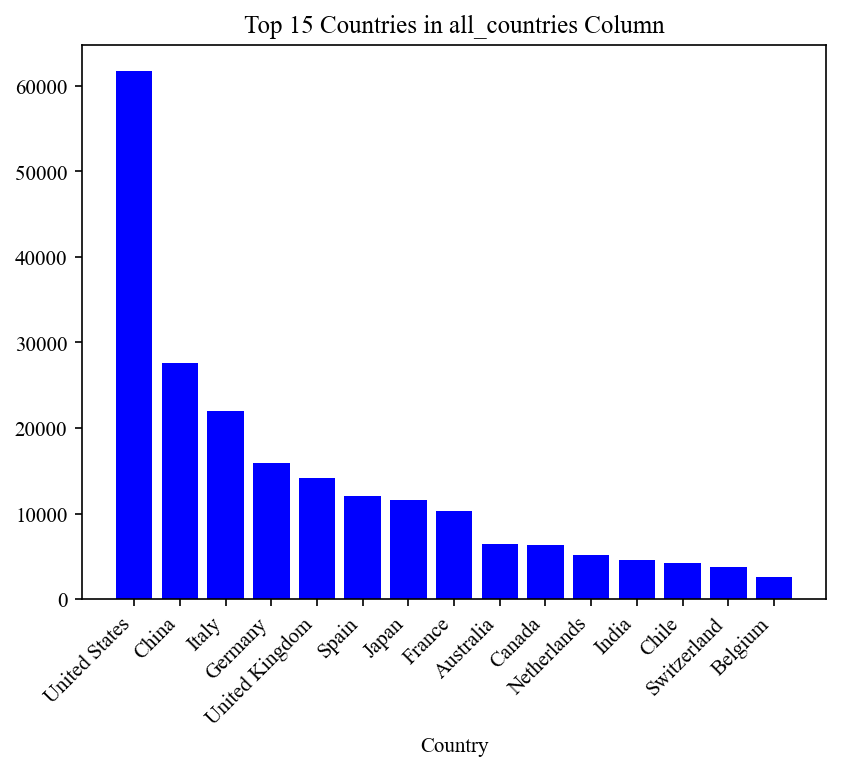

In [13]:
# Histogram of Top 15 Countries in 'all_countries' column
from collections import Counter
country_counter = Counter()
for countries in data['all_countries']:
    for country in countries:
        country_counter[country] += 1
top_15 = country_counter.most_common(15)
countries, counts = zip(*top_15)
plt.bar(countries, counts, color='blue')
plt.xticks(rotation=45, ha='right')
plt.title('Top 15 Countries in all_countries Column')
plt.xlabel('Country')
plt.show()

In [14]:
# Percentage that the 'US' and 'China' represent in 'all_countries' column
total_count = 0
us_count = 0
china_count = 0
for countries in data['all_countries']:
    for country in countries:
        total_count += 1
        if country == 'United States':
            us_count += 1
        elif country == 'China':
            china_count += 1
us_percentage = (us_count / total_count) * 100 if total_count > 0 else 0
china_percentage = (china_count / total_count) * 100 if total_count > 0 else 0
print(f"US Percentage: {us_percentage:.2f}%")
print(f"China Percentage: {china_percentage:.2f}%")

US Percentage: 25.61%
China Percentage: 11.43%


Text(0.5, 0, 'Country')

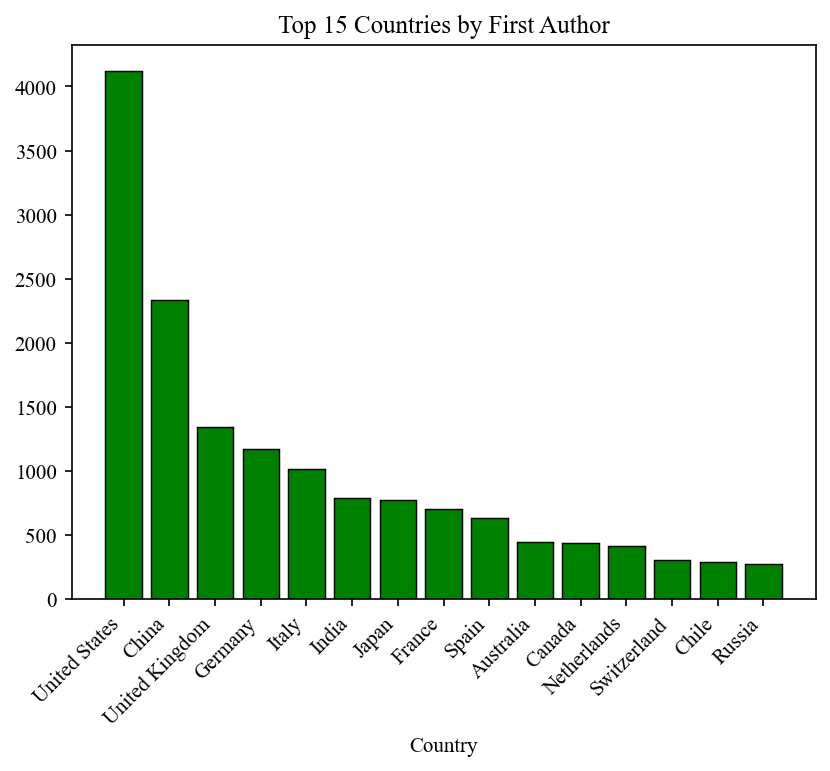

In [18]:
# Histogram ofr top 15 countriesin 'first_author' column
country_counts = []
for countries in data['first_author']:
    for country in countries:
        country_counts.append(country)
from collections import Counter
country_counter = Counter(country_counts)
top_15 = country_counter.most_common(15)
countries, counts = zip(*top_15)
plt.bar(countries, counts, color='green', edgecolor='black', linewidth=0.7)
plt.xticks(rotation=45, ha='right')
plt.title('Top 15 Countries by First Author')
plt.xlabel('Country')

In [16]:
# Percentage that the 'US' and 'China' represent in 'first_author' column
total_count = 0
us_count = 0
china_count = 0
for countries in data['first_author']:
    for country in countries:
        total_count += 1
        if country == 'United States':
            us_count += 1
        elif country == 'China':
            china_count += 1
us_percentage = (us_count / total_count) * 100 if total_count > 0 else 0
china_percentage = (china_count / total_count) * 100 if total_count > 0 else 0
print(f"US Percentage (First Author): {us_percentage:.2f}%")
print(f"China Percentage (First Author): {china_percentage:.2f}%")

US Percentage (First Author): 22.82%
China Percentage (First Author): 12.91%


In [17]:
# Number of Unique Countires in 'first_author' column
unique_countries = set()
for countries in data['first_author']:
    for country in countries:
        unique_countries.add(country)
print(len(unique_countries))

105


In [27]:
# Collaboration between countries in 'all_countries' column
collaboration_counts = {}
for countries in data['all_countries']:
    unique_countries = set(countries)
    country_list = list(unique_countries)
    n = len(country_list)
    for i in range(n):
        for j in range(i + 1, n):
            pair = tuple(sorted([country_list[i], country_list[j]]))
            if pair in collaboration_counts:
                collaboration_counts[pair] += 1
            else:
                collaboration_counts[pair] = 1
# Display top 10 collaborations
top_collaborations = sorted(collaboration_counts.items(), key=lambda x: x[1], reverse=True)[:10]
for pair, count in top_collaborations:
    print(f"{pair[0]} - {pair[1]}: {count}")

United Kingdom - United States: 2524
Germany - United States: 2308
Italy - United States: 1820
France - United States: 1623
Germany - United Kingdom: 1514
Spain - United States: 1492
Germany - Italy: 1402
Italy - United Kingdom: 1363
Canada - United States: 1314
China - United States: 1234


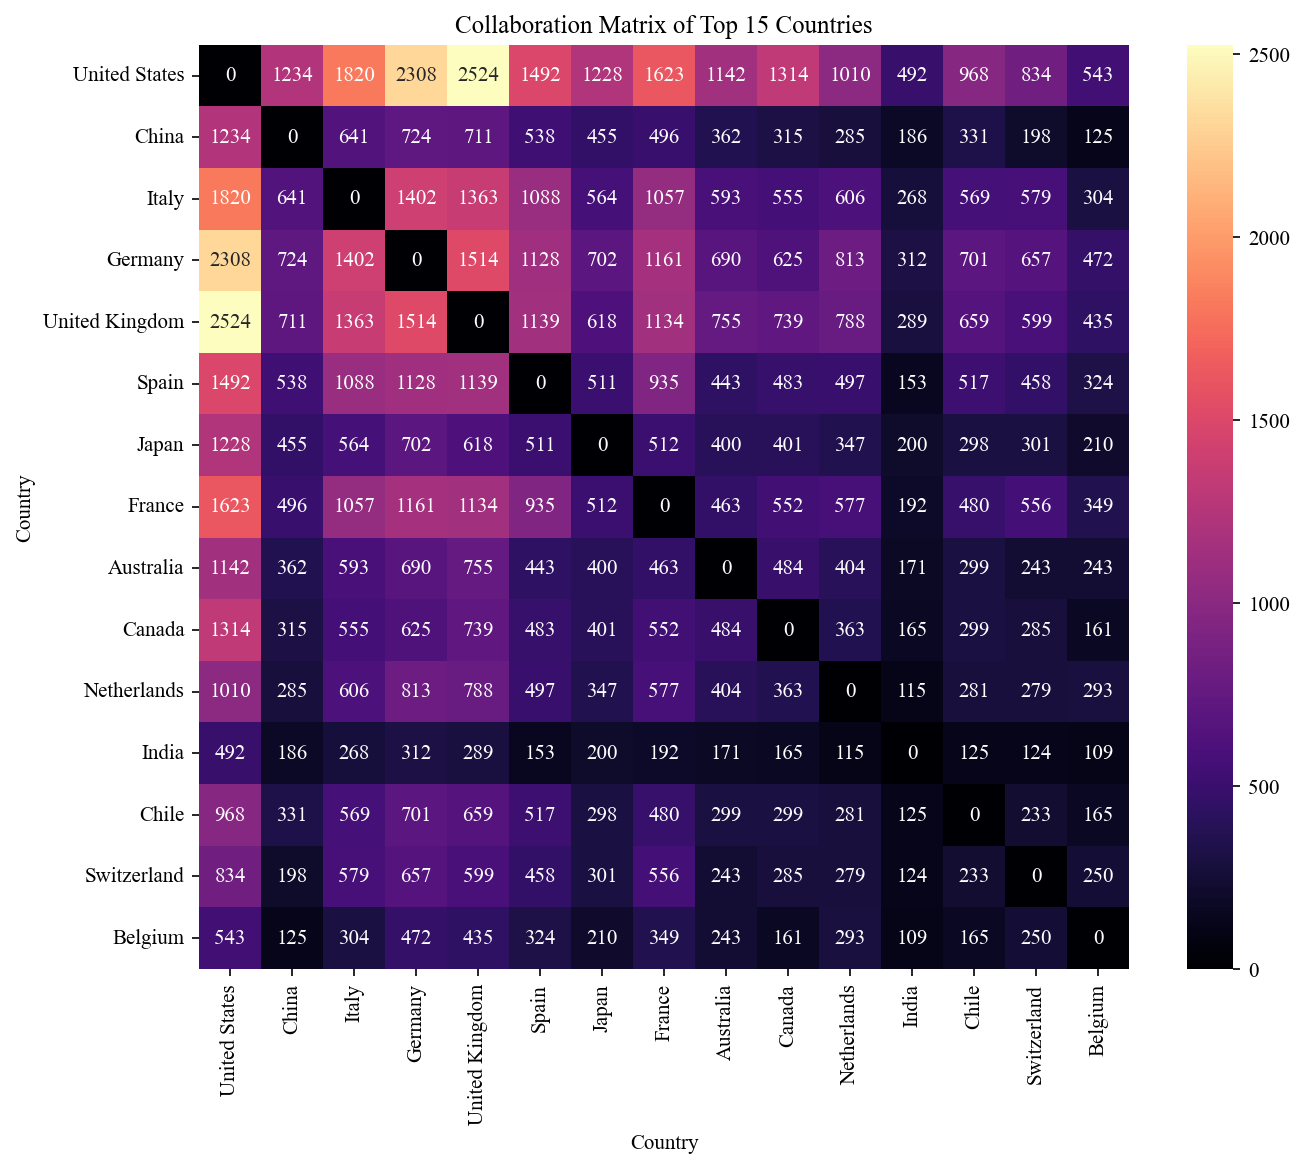

In [33]:
# Confusion Matrix like plot of the top 15 versus top 15 countries in 'all_countries' column with each cell having the number of collaborations between the two countries
import seaborn as sns
from collections import Counter
# Get top 15 countries
country_counter = Counter()
for countries in data['all_countries']:
    for country in countries:
        country_counter[country] += 1
top_15 = [country for country, count in country_counter.most_common(15)]
# Initialize collaboration matrix
collab_matrix = pd.DataFrame(0, index=top_15, columns=top_15)
# Populate the matrix
for countries in data['all_countries']:
    unique_countries = set(countries)
    filtered_countries = [c for c in unique_countries if c in top_15]
    n = len(filtered_countries)
    for i in range(n):
        for j in range(i + 1, n):
            c1 = filtered_countries[i]
            c2 = filtered_countries[j]
            collab_matrix.at[c1, c2] += 1
            collab_matrix.at[c2, c1] += 1
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(collab_matrix, annot=True, fmt='d', cmap='magma')
plt.title('Collaboration Matrix of Top 15 Countries')
plt.xlabel('Country')
plt.ylabel('Country')
plt.show()

In [40]:
# Number of papers with a single author in the authors column
single_author_count = 0
for authors in data['authors']:
    if isinstance(authors, str):
        author_list = [a.strip() for a in authors.split(',') if a.strip()]
        if len(author_list) == 1:
            single_author_count += 1
print(single_author_count)


# Percentage of papers with a single author in the authors column
total_papers = len(data)
percentage_single_author = (single_author_count / total_papers) * 100 if total_papers > 0 else 0
print(f"Percentage of Single Author Papers: {percentage_single_author:.2f}%")

1330
Percentage of Single Author Papers: 7.13%


In [37]:
# Percentage of papers with no repeated countries in 'all_countries' column
# Filter to only consider papers with more than 1 country listed
relevant_countries_lists = [c for c in data['all_countries'] if len(c) > 1]
total_papers = len(relevant_countries_lists)

no_repeat_count = 0
for countries in relevant_countries_lists:
    if len(countries) == len(set(countries)):
        no_repeat_count += 1

no_repeat_percentage = (no_repeat_count / total_papers) * 100 if total_papers > 0 else 0
print(f"Analyzing {total_papers} papers with >1 country listed.")
print(f"Number of papers with no repeated countries: {no_repeat_count}")
print(f"Percentage of papers with no repeated countries: {no_repeat_percentage:.2f}%")

Analyzing 16485 papers with >1 country listed.
Number of papers with no repeated countries: 730
Percentage of papers with no repeated countries: 4.43%


In [41]:
# Average number of authors on a paper from the 'authors' column
total_authors = 0
for authors in data['authors']:
    if isinstance(authors, str):
        author_list = [a.strip() for a in authors.split(',') if a.strip()]
        total_authors += len(author_list)
average_authors = total_authors / len(data) if len(data) > 0 else 0
print(f"Average number of authors per paper: {average_authors:.2f}")

Average number of authors per paper: 10.19


In [50]:
# Average number of authors from the same contry in 'all_countries' column
total_same_country_authors = 0
for index, row in data.iterrows():
    authors = row['authors']
    countries = row['all_countries']
    if isinstance(authors, str) and isinstance(countries, list) and len(countries) > 0:
        author_list = [a.strip() for a in authors.split(',') if a.strip()]
        num_authors = len(author_list)
        num_countries = len(countries)
        if num_countries > 0:
            avg_authors_per_country = num_authors / num_countries
            total_same_country_authors += avg_authors_per_country
average_same_country_authors = total_same_country_authors / len(data) if len(data) > 0 else 0
print(f"Average number of authors from the same country per paper: {average_same_country_authors:.2f}")

# Average number of authors from the same county in 'all_countires' column as the first author in 'first_author' column
total_first_author_country_authors = 0
for index, row in data.iterrows():
    authors = row['authors']
    countries = row['all_countries']
    first_author_countries = row['first_author']
    if (isinstance(authors, str) and isinstance(countries, list) and 
        len(countries) > 0 and isinstance(first_author_countries, list) and 
        len(first_author_countries) > 0):
        
        first_country = first_author_countries[0]
        # Count how many times the first author's country appears in the list
        if first_country in countries:
            count_from_first_country = countries.count(first_country)
            total_first_author_country_authors += count_from_first_country
            
average_first_author_country_authors = (total_first_author_country_authors / len(data)) if len(data) > 0 else 0
print(f"Average number of authors from the same country as the first author per paper: {average_first_author_country_authors:.2f}")

Average number of authors from the same country per paper: 1.67
Average number of authors from the same country as the first author per paper: 6.27


In [56]:
# Initialize metrics columns
data['LCI'] = np.nan
data['LCR'] = np.nan
data['GCI'] = np.nan
data['NGCI'] = np.nan

# Calculate indices in a single loop for efficiency
for index, row in data.iterrows():
    authors = row['authors']
    countries = row['all_countries']
    first_author_countries = row['first_author']
    
    # Basic validation that data exists
    has_authors = isinstance(authors, str)
    has_countries = isinstance(countries, list) and len(countries) > 0
    has_first = isinstance(first_author_countries, list) and len(first_author_countries) > 0
    
    if has_authors and has_countries and has_first:
        author_list = [a.strip() for a in authors.split(',') if a.strip()]
        num_authors = len(author_list)
        first_country = first_author_countries[0]
        
        # 1. Local Collaboration Index (LCI)
        # Number of affiliations from the same country as the first author
        lci_val = countries.count(first_country)
        data.at[index, 'LCI'] = lci_val
        
        # 2. Local Collaborative Ratio (LCR)
        # Ratio of LCI to the total number of authors
        if num_authors > 0:
            data.at[index, 'LCR'] = lci_val / num_authors
            
        # 3. Global Collaboration Index (GCI)
        # Number of affiliations from countries different from the first author
        # (Total affiliations - Local affiliations)
        gci_val = len(countries) - lci_val
        data.at[index, 'GCI'] = gci_val
        
        # 4. Non-repeated Global Collaboration Index (NGCI)
        # Number of unique countries excluding the first author's country
        unique_other_countries = set(countries) - {first_country}
        data.at[index, 'NGCI'] = len(unique_other_countries)


In [57]:
data

,title,abstract,authors,figures,pages,tables,pdf_link,primary_subject,secondary_subjects,submitted_journal,...,smart_keywords,smart_keywords_2,latex_countries,affil_countries,all_countries,first_author,LCI,LCR,GCI,NGCI
0,Insights on Galaxy Evolution from Interpretabl...,Galaxy appearances reveal the physics of how t...,['John F. Wu'],4.0,10.0,2.0,arxiv.org/pdf/2501.00089,Astrophysics of Galaxies,['Machine Learning'],AAS Journals,...,"['Astronomers', 'Astronomical evolution', 'Ast...","['Galaxies (573)', 'Astronomy image processing...",NaN,"[United States, United States, United States]","[United States, United States, United States]",[United States],3.0,3.000000,0.0,0.0
1,X-ray reverberation black hole mass and distan...,We fit X-ray reverberation models to Rossi X-r...,"[""Patrick O'Neill"", 'Adam Ingram', 'Edward Nat...",16.0,18.0,1.0,arxiv.org/pdf/2501.12788,High Energy Astrophysical Phenomena,NaN,NaN,...,"['Accretion', 'Angular distance', 'Bayesian st...",['powered by accretion of matter from a compan...,"United Kingdom, United Kingdom, United Kingdom...",[],"[United Kingdom, United Kingdom, United Kingdo...",[United Kingdom],3.0,0.428571,4.0,4.0
2,The TES-based Cryogenic AntiCoincidence Detect...,The Cryogenic AntiCoincidence Detector (CryoAC...,"[""Matteo D'Andrea"", 'Claudio Macculi', 'Simone...",17.0,8.0,0.0,arxiv.org/pdf/2501.12781,Instrumentation and Methods for Astrophysics,NaN,IEEE Transactions on Applied Superconductivity...,...,[],[],NaN,"[Italy, Italy, Italy, Italy, Italy, Italy, Ita...","[Italy, Italy, Italy, Italy, Italy, Italy, Ita...",[Italy],21.0,1.312500,0.0,0.0
3,Massive star clusters in the gamma-ray sky: th...,Massive Star Clusters (SCs) have been proposed...,"['Giada Peron', 'Giovanni Morlino', 'Stefano G...",3.0,5.0,1.0,arxiv.org/pdf/2501.12767,High Energy Astrophysical Phenomena,NaN,NaN,...,"['Cosmic ray objects', 'Cosmic ray sources', '...","['Cosmic Rays 1', 'HII regions', 'Gamma rays',...","Italy, France",[],"[Italy, France]",[Italy],1.0,0.250000,1.0,1.0
4,The Impact of Bar-induced Non-Circular Motions...,We study the impact of bar-induced non-circula...,"['Jie Liu', 'Zhi Li', 'Juntai Shen']",12.0,19.0,1.0,arxiv.org/pdf/2501.12760,Astrophysics of Galaxies,NaN,NaN,...,"['Disk galaxies', 'Galactic bar', 'Galaxies']",['galaxies: rotation curve - galaxies: fundame...,Germany,"[China, China, China, China, China, China]","[China, China, China, China, China, China]",[China],6.0,2.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18655,Cosmic Himalayas in CROCODILE : Probing the Ex...,The recently reported Cosmic Himalayas (CH) --...,"['Yuto Kuwayama', 'Yongming Liang', 'Kentaro N...",10.0,18.0,5.0,arxiv.org/pdf/2512.24966,Cosmology and Nongalactic Astrophysics,['Astrophysics of Galaxies'],NaN,...,"['Apparent anomaly', 'Clustering', 'Cosmologic...",['Hydrodynamicalsimulations(767)'],"Japan, Japan, Japan, Japan, Japan, Japan, Unit...",[],"[Japan, Japan, Japan, Japan, Japan, Japan, Uni...",[Japan],15.0,1.500000,3.0,2.0
18656,Multi-Frequency Study of FRB20201124A with the...,We present results from multi-epoch observatio...,"['C. Dudeja', 'J. Roy', 'U. Panda', 'S. Bhatta...",11.0,17.0,1.0,arxiv.org/pdf/2512.24978,High Energy Astrophysical Phenomena,NaN,NaN,...,"['FRB', 'FRBs', 'Fast radio burst']",[],"India, India, India, India",[],"[India, India, India, India]",[India],4.0,1.000000,0.0,0.0
18657,Distributions of wide binary stars in theory a...,"Using the censored catalog of 103,169 resolved...",['Valeri V. Makarov'],7.0,13.0,1.0,arxiv.org/pdf/2512.25002,Solar and Stellar Astrophysics,NaN,NaN,...,"['A stars', 'A type stars', 'A-type stars']",[],United States,[],[United States],[United States],1.0,1.000000,0.0,0.0
18658,Towards precision cosmology with Voids x CMB c...,We construct and validate a set of multi-purpo...,"['Mar Pérez Sar', 'Carlos Hernández Monteagudo...",8.0,19.0,1.0,arxiv.org/pdf/2512.25040,Cosmology and Nongalactic Astrophysics,NaN,NaN,...,

In [58]:
# Average LCI
median_lci = data['LCI'].median()
print(f"Median LCI: {median_lci:.2f}")
average_lci = data['LCI'].mean()
print(f"Average LCI: {average_lci:.2f}")
# Average LCR
median_lcr = data['LCR'].median()
print(f"Median LCR: {median_lcr:.2f}")
average_lcr = data['LCR'].mean()
print(f"Average LCR: {average_lcr:.2f}")
# Average GCI
median_gci = data['GCI'].median()
print(f"Median GCI: {median_gci:.2f}")
average_gci = data['GCI'].mean()
print(f"Average GCI: {average_gci:.2f}")
# Average NGCI
median_ngci = data['NGCI'].median()
print(f"Median NGCI: {median_ngci:.2f}")
average_ngci = data['NGCI'].mean()
print(f"Average NGCI: {average_ngci:.2f}")

Median LCI: 4.00
Average LCI: 6.48
Median LCR: 0.86
Average LCR: 1.03
Median GCI: 1.00
Average GCI: 6.86
Median NGCI: 1.00
Average NGCI: 1.98


In [66]:
# What percentage of papers come from the mega collaborations like CERN, LIGO, etc. defined as having more than 100 authors in the 'authors' column
mega_collab_count = 0
for authors in data['authors']:
    if isinstance(authors, str):
        author_list = [a.strip() for a in authors.split(',') if a.strip()]
        if len(author_list) > 20:
            mega_collab_count += 1
total_papers = len(data)
mega_collab_percentage = (mega_collab_count / total_papers) * 100 if total_papers > 0 else 0
print(f"Percentage of Mega Collaboration Papers (>20 authors): {mega_collab_percentage:.2f}%")
print("Number of Mega Collaboration Papers:", mega_collab_count)

Percentage of Mega Collaboration Papers (>20 authors): 10.61%
Number of Mega Collaboration Papers: 1979


In [68]:
# Percentage of papers from small teams defined as having 3 or fewer authors in the 'authors' column
small_team_count = 0
for authors in data['authors']:
    if isinstance(authors, str):
        author_list = [a.strip() for a in authors.split(',') if a.strip()]
        if len(author_list) <= 5:
            small_team_count += 1
total_papers = len(data)
small_team_percentage = (small_team_count / total_papers) * 100 if total_papers > 0 else 0
print(f"Percentage of Small Team Papers (<=3 authors): {small_team_percentage:.2f}%")
print("Number of Small Team Papers:", small_team_count)

Percentage of Small Team Papers (<=3 authors): 53.60%
Number of Small Team Papers: 10001


In [82]:
# Highest LCI value and corresponding paper details
max_lci = data['LCI'].max()
max_lci_papers = data[data['LCI'] == max_lci]
print(f"Highest LCI Value: {max_lci}")
print("Papers with Highest LCI:")
print(max_lci_papers[['title', 'authors','LCI']])

# Highest LCR value and corresponding paper details
unique_lcr_values = sorted(data['LCR'].unique(), reverse=True)
if len(unique_lcr_values) > 1:
    second_max_lcr = unique_lcr_values[3]
    second_lcr_papers = data[data['LCR'] == second_max_lcr]
    print(f"Second Highest LCR Value: {second_max_lcr}")
    print("Papers with Second Highest LCR:")
    print(second_lcr_papers[['title', 'authors', 'LCR']])
else:
    print("Not enough unique LCR values to determining the second highest.")

# Highest GCI value and corresponding paper details
max_gci = data['GCI'].max()
max_gci_papers = data[data['GCI'] == max_gci]
print(f"Highest GCI Value: {max_gci}")
print("Papers with Highest GCI:")
print(max_gci_papers[['title', 'authors', 'GCI']])

# Highest NGCI value and corresponding paper details
max_ngci = data['NGCI'].max()
max_ngci_papers = data[data['NGCI'] == max_ngci]
print(f"Highest NGCI Value: {max_ngci}")
print("Papers with Highest NGCI:")
print(max_ngci_papers[['title', 'authors', 'NGCI']])

Highest LCI Value: 468.0
Papers with Highest LCI:
                                                   title  \
16086  Precise Measurement of Cosmic Ray Light and He...   

                        authors    LCI  
16086  ['LHAASO collaboration']  468.0  
Second Highest LCR Value: 149.0
Papers with Second Highest LCR:
                                                  title  \
2587  On the potential cosmogenic origin of the ultr...   

                       authors    LCR  
2587  ['KM3NeT collaboration']  149.0  
Highest GCI Value: 2133.0
Papers with Highest GCI:
                                                   title  \
10820  GWTC-4.0: Population Properties of Merging Com...   

                                                 authors     GCI  
10820  ['LIGO Scientific Collaboration', 'Virgo Colla...  2133.0  
Highest NGCI Value: 57.0
Papers with Highest NGCI:
                                                  title  \
5242  The CosmoVerse White Paper: Addressing observa...   

        

In [87]:
data['title'][5242]

'The CosmoVerse White Paper: Addressing observational tensions in cosmology with systematics and fundamental physics'

In [88]:
# List of top 10 Most internationally collaborative countries on average
from collections import defaultdict
country_gci_totals = defaultdict(int)
country_paper_counts = defaultdict(int)
for index, row in data.iterrows():
    countries = row['all_countries']
    gci = row['GCI']
    
    if isinstance(countries, list) and len(countries) > 0 and pd.notna(gci):
        for country in countries:
            country_gci_totals[country] += gci
            country_paper_counts[country] += 1
# Calculate average GCI per country
country_avg_gci = {}
for country in country_gci_totals:
    total_gci = country_gci_totals[country]
    paper_count = country_paper_counts[country]
    if paper_count > 0:
        country_avg_gci[country] = total_gci / paper_count
# Get top 10 countries by average GCI
top_10_international = sorted(country_avg_gci.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 Most Internationally Collaborative Countries on Average:")
for country, avg_gci in top_10_international:
    print(f"{country}: {avg_gci:.2f}")

Top 10 Most Internationally Collaborative Countries on Average:
Burkina Faso: 730.57
Mali: 534.50
Bosnia and Herzegovina: 477.00
Albania: 477.00
Italy: 281.79
Taiwan: 271.91
Belgium: 262.37
Netherlands: 247.68
France: 206.34
India: 194.14


In [91]:
# List of Top 10 Most locally collaborative countries by Average LCI
country_lci_totals = defaultdict(int)
country_paper_counts = defaultdict(int)
for index, row in data.iterrows():
    countries = row['all_countries']
    lci = row['LCI']
    
    if isinstance(countries, list) and len(countries) > 0 and pd.notna(lci):
        for country in countries:
            country_lci_totals[country] += lci
            country_paper_counts[country] += 1
# Calculate average LCI per country
country_avg_lci = {}
for country in country_lci_totals:
    total_lci = country_lci_totals[country]
    paper_count = country_paper_counts[country]
    if paper_count > 0:
        country_avg_lci[country] = total_lci / paper_count
# Get top 10 countries by average LCI
top_10_local = sorted(country_avg_lci.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 Most Locally Collaborative Countries on Average:")
for country, avg_lci in top_10_local:
    print(f"{country}: {avg_lci:.2f}")

Top 10 Most Locally Collaborative Countries on Average:
Mayotte: 80.36
China: 55.60
Morocco: 55.00
Burkina Faso: 53.64
Thailand: 46.50
Algeria: 45.69
Georgia: 37.69
Belgium: 37.36
Mali: 37.25
Bosnia and Herzegovina: 36.00


In [92]:
# List of Top 10 Most locally collaborative countries by Average LCR
country_lcr_totals = defaultdict(float)
country_paper_counts = defaultdict(int)
for index, row in data.iterrows():
    countries = row['all_countries']
    lcr = row['LCR']
    
    if isinstance(countries, list) and len(countries) > 0 and pd.notna(lcr):
        for country in countries:
            country_lcr_totals[country] += lcr
            country_paper_counts[country] += 1
# Calculate average LCR per country
country_avg_lcr = {}
for country in country_lcr_totals:
    total_lcr = country_lcr_totals[country]
    paper_count = country_paper_counts[country]
    if paper_count > 0:
        country_avg_lcr[country] = total_lcr / paper_count
# Get top 10 countries by average LCR
top_10_local_ratio = sorted(country_avg_lcr.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 Most Locally Collaborative Countries by Average LCR:")
for country, avg_lcr in top_10_local_ratio:
    print(f"{country}: {avg_lcr:.2f}")

Top 10 Most Locally Collaborative Countries by Average LCR:
Mayotte: 24.65
China: 23.61
Thailand: 17.39
Morocco: 14.50
Algeria: 13.89
Mali: 12.58
Hong Kong: 10.37
Russia: 9.80
Armenia: 9.28
Burkina Faso: 7.23


In [93]:
# List of top 10 Most internationally collaborative countries by Average NGCI
country_ngci_totals = defaultdict(int)
country_paper_counts = defaultdict(int)
for index, row in data.iterrows():
    countries = row['all_countries']
    ngci = row['NGCI']
    
    if isinstance(countries, list) and len(countries) > 0 and pd.notna(ngci):
        for country in countries:
            country_ngci_totals[country] += ngci
            country_paper_counts[country] += 1
# Calculate average NGCI per country
country_avg_ngci = {}
for country in country_ngci_totals:
    total_ngci = country_ngci_totals[country]
    paper_count = country_paper_counts[country]
    if paper_count > 0:
        country_avg_ngci[country] = total_ngci / paper_count
# Get top 10 countries by average NGCI
top_10_international_ngci = sorted(country_avg_ngci.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 Most Internationally Collaborative Countries by Average NGCI:")
for country, avg_ngci in top_10_international_ngci:
    print(f"{country}: {avg_ngci:.2f}")

Top 10 Most Internationally Collaborative Countries by Average NGCI:
Bosnia and Herzegovina: 57.00
Albania: 57.00
Philippines: 15.29
Romania: 13.69
Lebanon: 13.68
Malta: 13.45
Burkina Faso: 13.43
Slovenia: 12.11
Morocco: 11.68
Montserrat: 11.50


In [96]:
# Folium maps of the LCI
import folium
from folium.plugins import HeatMap
# Load world coordinates
world_coords = pd.read_csv('/Users/ainsleylewis/Documents/Astronomy/arXiver/world_coords.csv')

In [ ]:
import time
import os
from selenium import webdriver

# LCI Map
lci_df = pd.DataFrame(list(country_avg_lci.items()), columns=['country', 'avg_lci'])

# Use the specific GeoJSON URL provided
political_countries_url = (
    "http://geojson.xyz/naturalearth-3.3.0/ne_50m_admin_0_countries.geojson"
)

# Initialize the map
m = folium.Map(location=(35, 0), zoom_start=2, tiles="cartodb positron")

# Add Choropleth layer
# Note: We set legend_name but we can also hide the default one if we want full Custom control. 
# However, folium's built-in legend is hard to style directly via Python args. 
# A common workaround is to use the 'branca' colormap or keep the default and add global CSS to scale it.
# Here we will add a global style injection to scale the legend svg and text.

folium.Choropleth(
    geo_data=political_countries_url,
    data=lci_df,
    columns=("country", "avg_lci"),
    key_on="feature.properties.name",
    fill_color="YlGnBu",
    fill_opacity=0.8,
    line_opacity=0.3,
    nan_fill_color="white",
    legend_name="Average Local Collaboration Index (LCI)",
).add_to(m)

# Inject CSS to make the legend larger
# standard folium legend class is .legend or .info.legend.leaflet-control
css_style = """
<style>
    /* Target the legend SVG and text */
    .legend {
        transform: scale(1.5); /* Scale up by 125% */
        transform-origin: top right; /* Origin for scaling */
        font-size: 14px; /* Base font size */
    }
    .legend text {
        font-weight: bold;
        font-size: 13px;
    }
</style>
"""
m.get_root().html.add_child(folium.Element(css_style))

# Add title
title_html = '''
     <h3 align="center" style="font-size:24px"><b>World Map of Average Local Collaboration Index (LCI)</b></h3>
             '''
m.get_root().html.add_child(folium.Element(title_html))

# Show map
m

# Save map to HTML file
m.save("average_lci_world_map.html")

# Define file paths
html_file = os.path.abspath("average_lci_world_map.html")
png_file = "average_lci_world_map.png"

# Setup WebDriver options (headless mode for running without UI)
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--window-size=1200,800')

# Initialize driver
driver = webdriver.Chrome(options=options)

try:
    # Load the local HTML file
    driver.get(f"file://{html_file}")
    
    # Give the map tiles time to load completely
    time.sleep(5)
    
    # Save screenshot
    driver.save_screenshot(png_file)
    print(f"Map successfully saved to {png_file}")
finally:
    driver.quit()

Map successfully saved to average_lci_world_map.png


In [120]:
# LCR Map
lcr_df = pd.DataFrame(list(country_avg_lcr.items()), columns=['country', 'avg_lcr'])

# Use the specific GeoJSON URL provided
political_countries_url = (
    "http://geojson.xyz/naturalearth-3.3.0/ne_50m_admin_0_countries.geojson"
)
# Initialize the map
m = folium.Map(location=(35, 0), zoom_start=2, tiles="cartodb positron")
# Add Choropleth layer
folium.Choropleth(
    geo_data=political_countries_url,
    data=lcr_df,
    columns=("country", "avg_lcr"),
    key_on="feature.properties.name",
    fill_color="YlGnBu",
    fill_opacity=0.8,
    line_opacity=0.3,
    nan_fill_color="white",
    legend_name="Average Local Collaborative Ratio (LCR)",
).add_to(m)

# Inject CSS to make the legend larger
css_style = """
<style>
    /* Target the legend SVG and text */
    .legend {
        transform: scale(1.5); /* Scale up by 125% */
        transform-origin: top right; /* Origin for scaling */
        font-size: 14px; /* Base font size */
    }
    .legend text {
        font-weight: bold;
        font-size: 13px;
    }
</style>
"""
m.get_root().html.add_child(folium.Element(css_style))
# Add title
title_html = '''
     <h3 align="center" style="font-size:24px"><b>World Map of Average Local Collaborative Ratio (LCR)</b></h3>
             '''
m.get_root().html.add_child(folium.Element(title_html))
# Show map
m
# Save map to HTML file
m.save("average_lcr_world_map.html")
# Define file paths
html_file = os.path.abspath("average_lcr_world_map.html")
png_file = "average_lcr_world_map.png"
# Setup WebDriver options (headless mode for running without UI)
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--window-size=1200,800')
# Initialize driver
driver = webdriver.Chrome(options=options)
try:
    # Load the local HTML file
    driver.get(f"file://{html_file}")
    
    # Give the map tiles time to load completely
    time.sleep(5)
    
    # Save screenshot
    driver.save_screenshot(png_file)
    print(f"Map successfully saved to {png_file}")
finally:
    driver.quit()

Map successfully saved to average_lcr_world_map.png


In [121]:
# GCI Map
gci_df = pd.DataFrame(list(country_avg_gci.items()), columns=['country', 'avg_gci'])
# Use the specific GeoJSON URL provided
political_countries_url = (
    "http://geojson.xyz/naturalearth-3.3.0/ne_50m_admin_0_countries.geojson"
)
# Initialize the map
m = folium.Map(location=(35, 0), zoom_start=2, tiles="cartodb positron")
# Add Choropleth layer
folium.Choropleth(
    geo_data=political_countries_url,
    data=gci_df,
    columns=("country", "avg_gci"),
    key_on="feature.properties.name",
    fill_color="YlGnBu",
    fill_opacity=0.8,
    line_opacity=0.3,
    nan_fill_color="white",
    legend_name="Average Global Collaboration Index (GCI)",
).add_to(m)
# Inject CSS to make the legend larger
css_style = """
<style>
    /* Target the legend SVG and text */
    .legend {
        transform: scale(1.5); /* Scale up by 125% */
        transform-origin: top right; /* Origin for scaling */
        font-size: 14px; /* Base font size */
    }
    .legend text {
        font-weight: bold;
        font-size: 13px;
    }
</style>
"""
m.get_root().html.add_child(folium.Element(css_style))
# Add title
title_html = '''
     <h3 align="center" style="font-size:24px"><b>World Map of Average Global Collaboration Index (GCI)</b></h3>
             '''
m.get_root().html.add_child(folium.Element(title_html))
# Show map
m
# Save map to HTML file
m.save("average_gci_world_map.html")
# Define file paths
html_file = os.path.abspath("average_gci_world_map.html")
png_file = "average_gci_world_map.png"
# Setup WebDriver options (headless mode for running without UI)
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--window-size=1200,800')
# Initialize driver
driver = webdriver.Chrome(options=options)
try:
    # Load the local HTML file
    driver.get(f"file://{html_file}")
    
    # Give the map tiles time to load completely
    time.sleep(5)
    
    # Save screenshot
    driver.save_screenshot(png_file)
    print(f"Map successfully saved to {png_file}")
finally:
    driver.quit()

Map successfully saved to average_gci_world_map.png


In [122]:
# NGCI Map
ngci_df = pd.DataFrame(list(country_avg_ngci.items()), columns=['country', 'avg_ngci'])
# Use the specific GeoJSON URL provided
political_countries_url = (
    "http://geojson.xyz/naturalearth-3.3.0/ne_50m_admin_0_countries.geojson"
)
# Initialize the map
m = folium.Map(location=(35, 0), zoom_start=2, tiles="cartodb positron")
# Add Choropleth layer
folium.Choropleth(
    geo_data=political_countries_url,
    data=ngci_df,
    columns=("country", "avg_ngci"),
    key_on="feature.properties.name",
    fill_color="YlGnBu",
    fill_opacity=0.8,
    line_opacity=0.3,
    nan_fill_color="white",
    legend_name="Average Normalized Global Collaboration Index (NGCI)",
).add_to(m)
# Inject CSS to make the legend larger
css_style = """
<style>
    /* Target the legend SVG and text */
    .legend {
        transform: scale(1.5); /* Scale up by 125% */
        transform-origin: top right; /* Origin for scaling */
        font-size: 14px; /* Base font size */
    }
    .legend text {
        font-weight: bold;
        font-size: 13px;
    }
</style>
"""
m.get_root().html.add_child(folium.Element(css_style))
# Add title
title_html = '''
     <h3 align="center" style="font-size:24px"><b>World Map of Average Normalized Global Collaboration Index (NGCI)</b></h3>
             '''
m.get_root().html.add_child(folium.Element(title_html))
# Show map
m
# Save map to HTML file
m.save("average_ngci_world_map.html")
# Define file paths
html_file = os.path.abspath("average_ngci_world_map.html")
png_file = "average_ngci_world_map.png"
# Setup WebDriver options (headless mode for running without UI)
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--window-size=1200,800')
# Initialize driver
driver = webdriver.Chrome(options=options)
try:
    # Load the local HTML file
    driver.get(f"file://{html_file}")
    
    # Give the map tiles time to load completely
    time.sleep(5)
    
    # Save screenshot
    driver.save_screenshot(png_file)
    print(f"Map successfully saved to {png_file}")
finally:
    driver.quit()

Map successfully saved to average_ngci_world_map.png


In [123]:
# Average LCI per Primary Subject in 'primary_subject' column
subject_lci_totals = defaultdict(int)
subject_paper_counts = defaultdict(int)
for index, row in data.iterrows():
    subject = row['primary_subject']
    lci = row['LCI']
    
    if pd.notna(subject) and pd.notna(lci):
        subject_lci_totals[subject] += lci
        subject_paper_counts[subject] += 1
# Calculate average LCI per subject
subject_avg_lci = {}
for subject in subject_lci_totals:
    total_lci = subject_lci_totals[subject]
    paper_count = subject_paper_counts[subject]
    if paper_count > 0:
        subject_avg_lci[subject] = total_lci / paper_count
# Display average LCI per primary subject
print("Average LCI per Primary Subject:")
for subject, avg_lci in subject_avg_lci.items():
    print(f"{subject}: {avg_lci:.2f}")

Average LCI per Primary Subject:
Astrophysics of Galaxies: 6.60
High Energy Astrophysical Phenomena: 7.84
Instrumentation and Methods for Astrophysics: 7.52
Solar and Stellar Astrophysics: 5.56
Cosmology and Nongalactic Astrophysics: 4.61
Earth and Planetary Astrophysics: 6.59
Astrophysics: 7.04
